# Выбор локации для скважины

Добывающей компании «ГлавРосГосНефть» необходимо решить задачу по определению локации (в данном случае региона)  для бурения новой скважины.  
Параметры отбора региона: выроятность убытков в регионе - менее 2,5%, средняя прибыль среди рассматриваемых регионов - наибольшая.

Аглоритм выбора локации:  

1. Сбор характеристик для скважин в избранном регионе: качество нефти и объём её запасов.   
У нас есть три датасета с характеристиками скважин по трём регионам, содержащие следующие признаки:  
*id — уникальный идентификатор скважины;  
*f0, f1, f2 — три признака точек;  
*product — объём запасов в скважине (тыс. баррелей).  
Данные синтетические.  

2. Построение модели и оценка объём запасов.  
В нашем случае будет использованиа линейная регресии.
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.  

3. Выбор месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины. 

4. Определение региона с максимальной суммарной прибылью отобранных скважин. 


Бизнес-показатели, на которые следует ориентироваться:  
Бюджет на разработку скважин в регионе — 10 млрд рублей.  
Один баррель сырья приносит 450 рублей дохода.  
Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

## Загрузка и подготовка данных

In [8]:
# загрузка библиотек
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

In [9]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [10]:
#задание глобальных переменных
STATE = 12335

In [11]:
# чтение датафреймов
df_list = []
for i in range(3):
    df = pd.read_csv(f'geo_data_{i}.csv')
    df_list.append(df)
df_1, df_2, df_3 = df_list
df_1.name, df_2.name, df_3.name = 'регион_1', 'регион_2', 'регион_3'

'регион_1'


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
16305,ePCSf,-0.742405,0.527503,3.667881,80.814574
38580,ZEqbe,0.776399,0.601258,6.961289,102.031893
28282,iLfPm,0.152969,-0.208423,0.940379,23.747368
53239,A658z,0.101906,0.130093,5.286574,79.107194
19371,mImrC,-0.082059,1.068062,-5.766613,21.695812
78997,GSij0,0.015777,0.474101,5.778886,106.536188
13291,SpFxs,-0.485006,0.782445,-3.792290,113.282658



Пропуски:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Описание датафрейма:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



Дубликаты:


0


Распределение признаков:


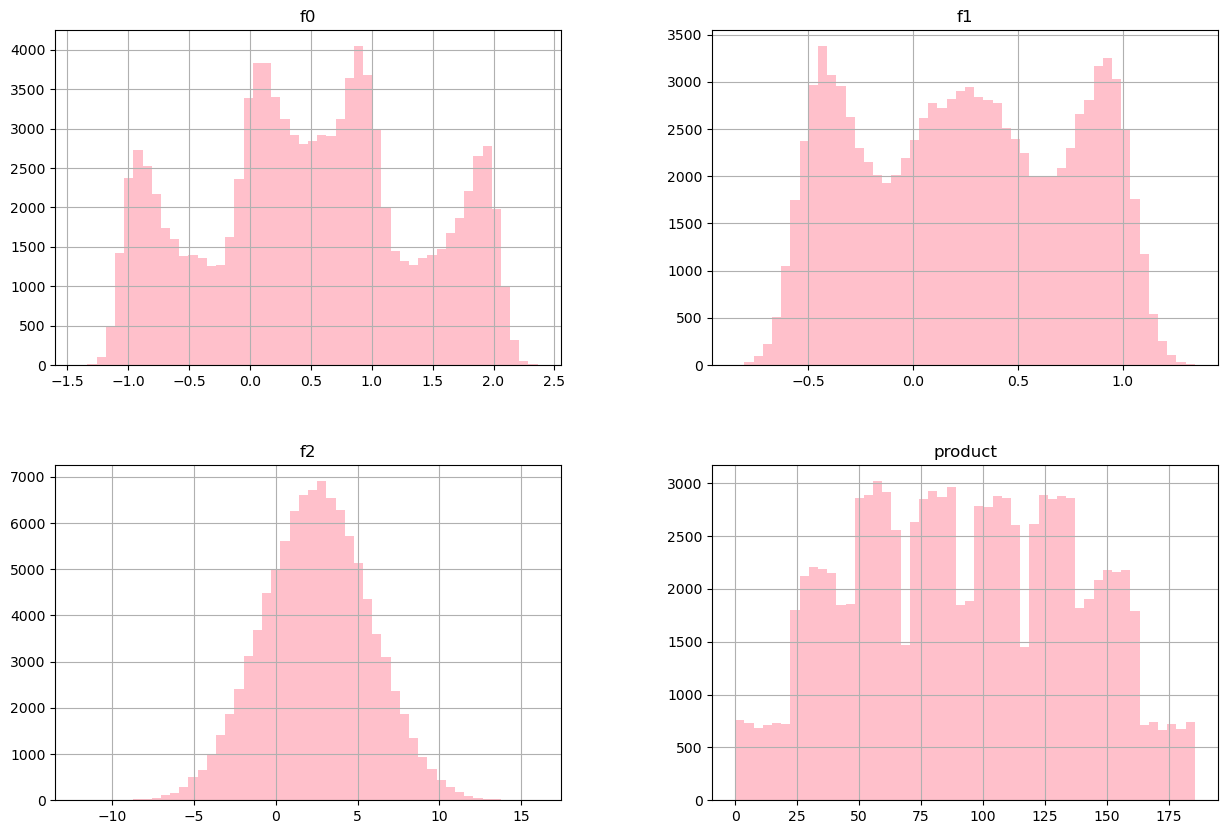


Корреляция признаков:


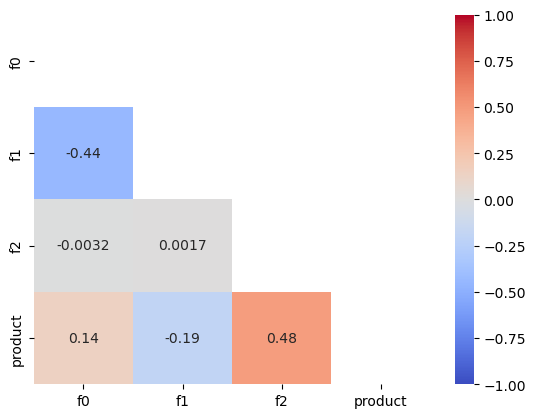

'регион_2'


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
71093,uw57o,6.372502,-6.596419,0.991733,26.953261
84389,G7wYy,7.863387,-6.559021,2.000091,57.085625
76951,BBfVn,7.216736,-1.609846,3.998263,107.813044
65728,SfVN4,6.066444,-1.432303,1.006322,26.953261
39799,KmgPX,4.356108,-10.973023,1.001809,26.953261
12504,TeRmo,-5.938612,-7.185551,1.999710,57.085625
11015,FW3en,1.115304,-3.782392,1.001442,26.953261



Пропуски:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Описание датафрейма:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



Дубликаты:


0


Распределение признаков:


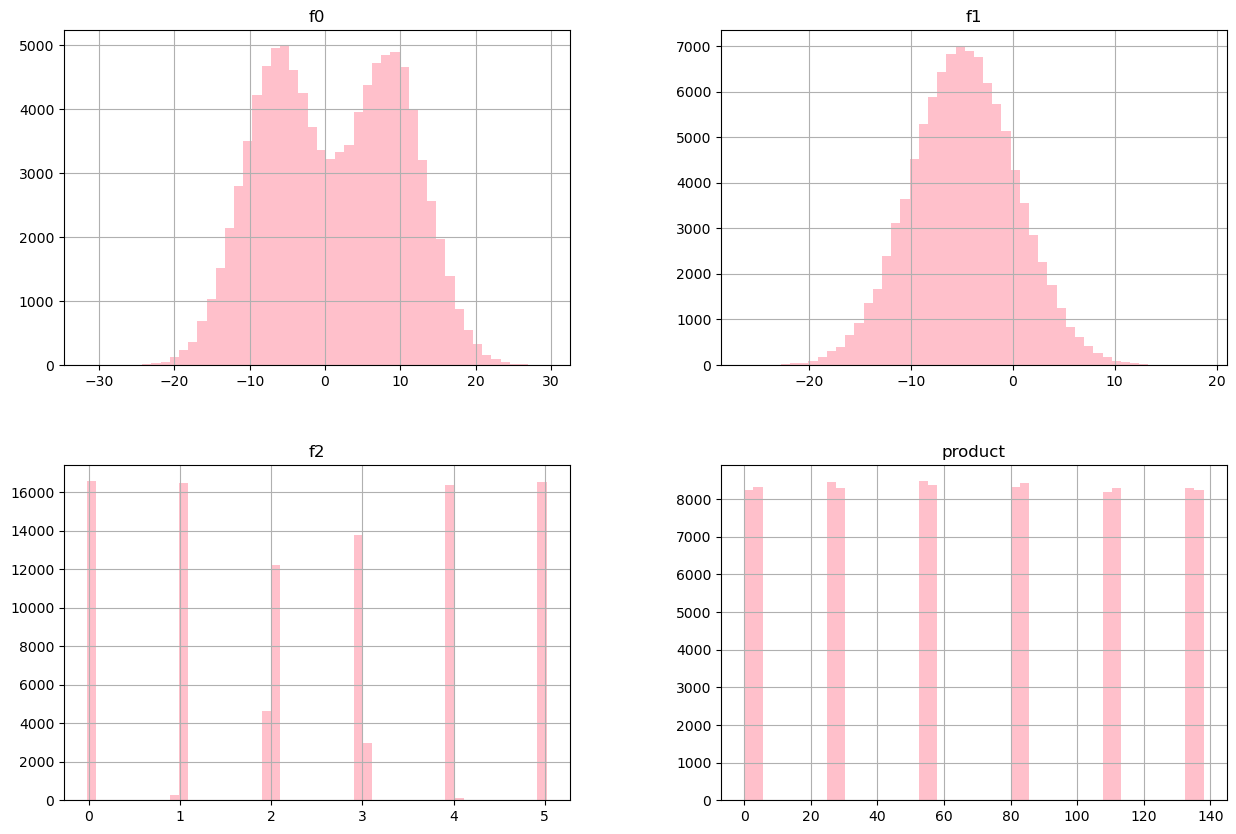


Корреляция признаков:


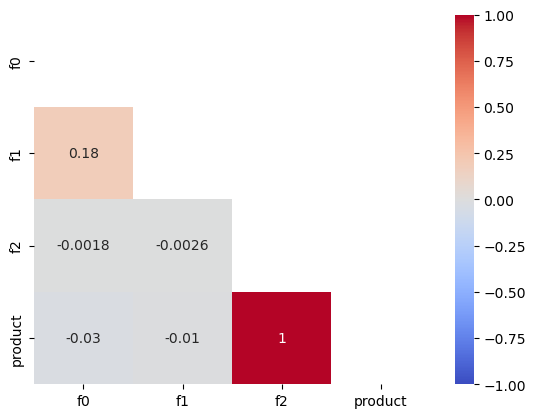

'регион_3'


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
30959,9ABsK,-0.911590,0.806552,2.202393,78.608655
80695,2ADXh,1.443657,-3.029949,5.308687,125.664374
26872,lV6kK,-0.884725,-2.009223,3.542445,186.311008
92258,97eoV,-0.586867,-0.222725,0.311477,57.428070
56208,7hJBx,-0.190025,1.165648,1.784632,39.609748
88601,cfN5F,-1.140038,1.792992,-1.533673,57.930708
52339,Do1xB,-1.275190,2.392184,-1.255773,54.271631



Пропуски:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Описание датафрейма:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838



Дубликаты:


0


Распределение признаков:


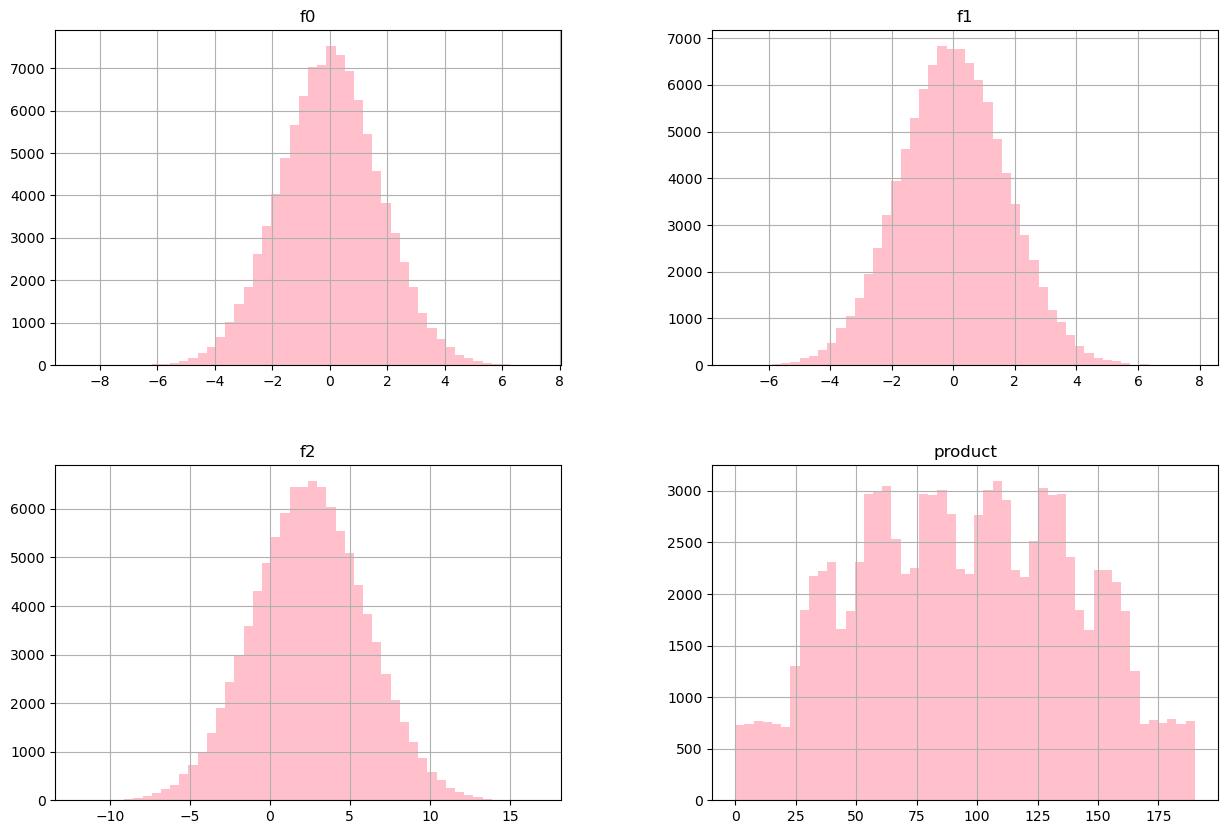


Корреляция признаков:


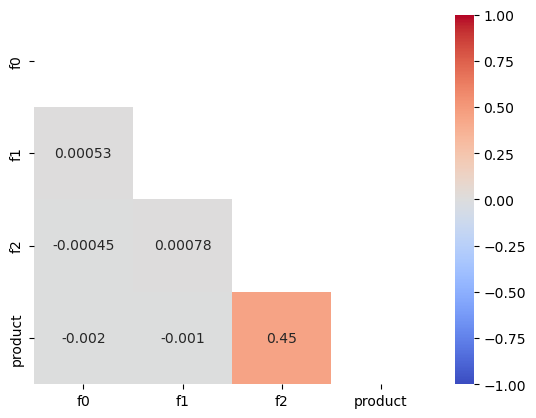

In [12]:
# просмотр информации о данных
for df in df_list:
        display(df.name)
        print('\nОбщая информация:')
        display(df.info())
        display(df.sample(7))
        print('\nПропуски:')
        display(df.isnull().sum().sort_values(ascending=False))
        print('\nОписание датафрейма:')
        display(df.describe())
        print('\nДубликаты:')
        display(df.duplicated().sum())
        print('\nРаспределение признаков:')
        df.hist(bins=50, figsize=(15, 10),color = 'pink')
        plt.show()
        print('\nКорреляция признаков:')
        corr = df.corr()
        maska = np.triu(df.corr())
        sns.heatmap(df.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask =  maska)
        plt.show()    

Все три датафрейма содержат 10000 строк и 5 столбцов.
Пропусков в данных по всем регионам нет.
Явных дубликатов нет.

Во втором датафрейме df_2 в признаке "product" уникальных значений всего 12, все данные распределены по ним.
Наблюдается корреляция признака f2 с признаком "product" во всех датафреймах. Во втором датафрей между признаками прямая зависимость.

Для масштабировани признаков применим робастное масштабирование RobustScaler, так как оно более устойчиво к возможным выбросам в данных. 

Столбец id удалим, для исследования не пригодится.

Наш таргетный признак - "product".

In [13]:
for df in df_list:
    print(f'{df.name}:\n{df.nunique()}\n')

регион_1:
id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

регион_2:
id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

регион_3:
id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64



In [14]:
# удалим стобцы "id" из всех датафреймов
for df in df_list:
    df.drop('id', axis=1, inplace=True)

## Обучение и проверка модели

Функция для разделения датафрейма на обучающую и валидационную выборки в соотношении 3:1, масштабирует признаки, возвращает предказания, таргет, RMSE

In [15]:
def split_and_fit(df):
 
    features = df.drop('product', axis=1)
    target = df['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=STATE)
    
    scaler = RobustScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    model = LinearRegression(normalize=False)
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    prediction = pd.Series(prediction)
    avg_product_pred = np.mean(prediction)
    avg_product_true = np.mean(target_valid)
    rmse = (mean_squared_error(prediction, target_valid))**(0.5)
    
    print('Cредний предсказанные запас: {0:.2f}'.format(avg_product_pred))
    print('Средний истинный запас: {0:.2f}'.format(avg_product_true))
    print('RMSE: {0:.2f}'.format(rmse))
    print('Размеры выборок', features_train.shape, features_valid.shape, target_train.shape, target_valid.shape)
    
    return (target_valid.reset_index(drop=True), prediction,rmse, avg_product_pred, avg_product_true)

In [16]:
display(df_1.name)
target_1, prediction_1, rmse_1, avg_1, avg_true_1 = split_and_fit(df_1)
display(df_2.name)
target_2, prediction_2, rmse_2, avg_2, avg_true_2 = split_and_fit(df_2)
display(df_3.name)
target_3, prediction_3, rmse_3, avg_3, avg_true_3 = split_and_fit(df_3)

'регион_1'

Cредний предсказанные запас: 92.64
Средний истинный запас: 91.98
RMSE: 37.65
Размеры выборок (75000, 3) (25000, 3) (75000,) (25000,)


'регион_2'

Cредний предсказанные запас: 68.77
Средний истинный запас: 68.77
RMSE: 0.89
Размеры выборок (75000, 3) (25000, 3) (75000,) (25000,)


'регион_3'

Cредний предсказанные запас: 94.76
Средний истинный запас: 95.12
RMSE: 40.00
Размеры выборок (75000, 3) (25000, 3) (75000,) (25000,)


In [17]:
# таблица для визуализации вывода:
result = pd.DataFrame({
    'Регион': [df_list[0].name, df_list[1].name, df_list[2].name], 
    'RMSE': [rmse_1, rmse_2, rmse_3], 
    'Предсказанный средний запас сырья': [avg_1, avg_2, avg_3], 
    'Истинный средний запас сырья': [avg_true_1, avg_true_2, avg_true_3],
    
})
pd.set_option('display.float_format', '{:.2f}'.format)
display(result)

,Регион,RMSE,Предсказанный средний запас сырья,Истинный средний запас сырья
0,регион_1,37.65,92.64,91.98
1,регион_2,0.89,68.77,68.77
2,регион_3,40.00,94.76,95.12


Для каждого региона обучена модель.  
Предсказанные средние значения запасов почти равны истинным по трем регионам.  
Прогнозируемые объемы запасов во втором регионе ниже, чем в первом и третьем.  
При этом значение RMSE для второго региона низкое, что возможно связано с прямой зависимостью признаков product и f2 в исходных данных.
Регионы 1 и 3 могут представлять больший интерес, т.к. запасы в них больше, чем во втором регионе.

## Подготовка к расчёту прибыли

Сохраним ключевые данные для расчёта в отдельных переменных

In [18]:
# количество точек при разведке региона
POINTS = 500

# количество лучших точек для разработки
BEST_POINTS = 200

# бюджет на разработку скважин в регионе
DEVELOPMENT_BUDGET = 1e10

# доход с одного барреля сырья в рублях
BARREL_REVENUE = 450

# доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей
PRODUCT_REVENUE = BARREL_REVENUE * 1000

# вероятность убытков меньше 2.5%
LOSS_PROBABILITY = 2.5

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины и сравним полученный объём сырья со средним запасом в каждом регионе, полученном в предсказании.

In [19]:
# необходимый объем нефти в регионе для безубыточной разработки
sufficient_volume_region = DEVELOPMENT_BUDGET / PRODUCT_REVENUE
print(f'Объём нефти в регионе для безубыточной разработки: {sufficient_volume_region:.2f} тыс. баррелей')

Объём нефти в регионе для безубыточной разработки: 22222.22 тыс. баррелей


In [20]:
# объем запасов одной скажины для безубыточной разработки 200 точек
break_even_volume = sufficient_volume_region / BEST_POINTS
print(f'Объём одной скажины для её безубыточной разработки: {break_even_volume:.2f} тыс. баррелей')

Объём одной скажины для её безубыточной разработки: 111.11 тыс. баррелей


In [21]:
point_average_revenue = DEVELOPMENT_BUDGET / BEST_POINTS
print('Средняя прибыль для скважины', point_average_revenue, 'руб.')


Средняя прибыль для скважины 50000000.0 руб.


In [22]:
pd.DataFrame({
    'Регион': [df_list[0].name, df_list[1].name, df_list[2].name], 
    'Истинный средний объём запасов': [avg_true_1, avg_true_2, avg_true_3], 
    'Необходимый расчётный объём запасов': [break_even_volume]*3    
})

,Регион,Истинный средний объём запасов,Необходимый расчётный объём запасов
0,регион_1,91.98,111.11
1,регион_2,68.77,111.11
2,регион_3,95.12,111.11


Cредние значения запасов для всех регионов ниже необходимого расчётного объема, что говорит о том, что при разработки скважин, выбранных случайно, высок риск не окупить затраты на разработку.   
Поэтому возьмем не 200 случайных, а 200 скважин с максимальными предсказанными значениями. Далее посчитаем выручку, полученную с этих скважин, вычтем бюджетные расходы и получим ожидемый доход.

## Расчёт прибыли и рисков 

In [23]:
def revenue(target, predicted, count):  
    # скважины с максимальными значениями предсказаний:
    predicted_sorted = predicted.sort_values(ascending=False)
    # целевое значение объёмов, соответствующее этим предсказаниям:
    selected = target[predicted_sorted.index][:count]
    return (sum(selected) * PRODUCT_REVENUE) - DEVELOPMENT_BUDGET

#print(revenue(target_1, prediction_1, BEST_POINTS))
#print(revenue(target_2, prediction_2, BEST_POINTS))
#print(revenue(target_3, prediction_3, BEST_POINTS))

Для нахождения распределения прибыли будем использовать технику Bootstrap на 1000 выборок. Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков.

'регион_1'

Средняя прибыль в регионе: 410.23 млн.руб
Доверительный интервал от -106.14 млн.руб. до 972.73 млн.руб
Риск: 0.062


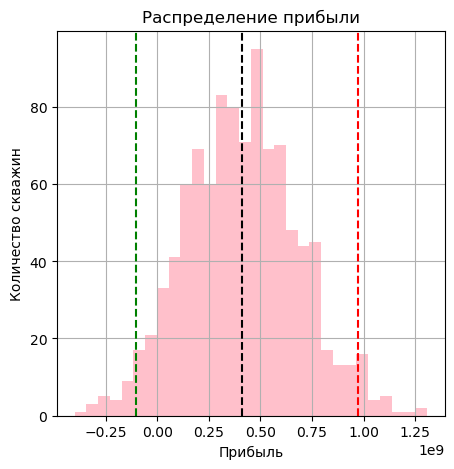

'регион_2'

Средняя прибыль в регионе: 526.8 млн.руб
Доверительный интервал от 134.48 млн.руб. до 930.07 млн.руб
Риск: 0.005


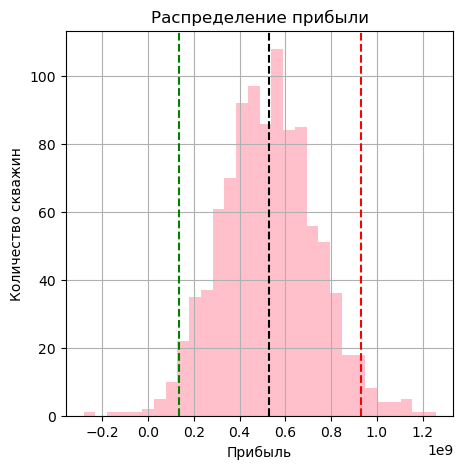

'регион_3'

Средняя прибыль в регионе: 388.53 млн.руб
Доверительный интервал от -156.44 млн.руб. до 953.37 млн.руб
Риск: 0.086


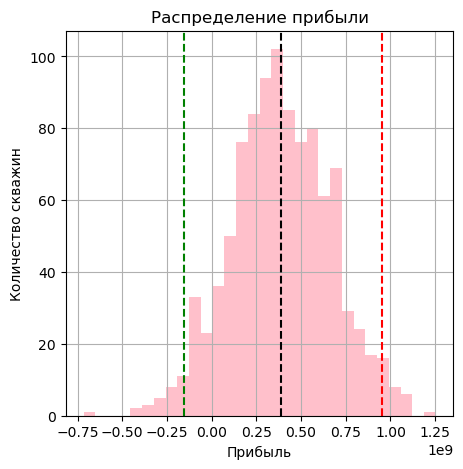

(0     -69860437.96
 1     698772890.84
 2     551332435.37
 3     471648608.92
 4     407617112.33
           ...     
 995   364719454.34
 996   538390861.41
 997   529201525.14
 998   206647823.15
 999   704500058.67
 Length: 1000, dtype: float64,
 -156442921.45935696,
 953365790.1368148,
 0.086)

In [24]:
def best_region(target, prediction):
    random_state = np.random.RandomState(seed=12345)
    values = []
    for i in range(1000):
        target_subsample = target.sample(POINTS, replace = True, random_state = random_state)
        preds_subsample = prediction[target_subsample.index]

        values.append(revenue(target_subsample, preds_subsample, BEST_POINTS))

    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    #risk = values[values < 0].count()/values.count()*100
    risk = (values < 0).mean()
    mean = values.mean()
    print('Средняя прибыль в регионе:', round(mean/10**6, 2), 'млн.руб')
    print('Доверительный интервал от', round(lower/10**6, 2),'млн.руб.', 'до', round(upper/10**6, 2),'млн.руб')
    print('Риск:', round(risk, 3))
    values.hist(bins=30, figsize=(5, 5), color='pink')
    plt.axvline(lower, color='g', linestyle='--')
    plt.axvline(upper, color='r', linestyle='--')
    plt.axvline(mean, color='black', linestyle='--')
    plt.title('Распределение прибыли')
    plt.xlabel('Прибыль')
    plt.ylabel('Количество скважин')
    plt.show()
    return values, lower, upper, risk


display(df_1.name)
best_region(target_1, prediction_1)
display(df_2.name)
best_region(target_2, prediction_2)
display(df_3.name)
best_region(target_3, prediction_3)

## Вывод:

Задача исследования - помочь компании «ГлавРосГосНефть» определиться с выбором региона для разработки месторождения нефти. 
Компанией предоставлены данные с характеристиками скважин в трёх регионах.
Данные прочитаны и сохранены в трёх датасетах, с которыми и велась работа: регион_1, регион_2, регион_3.
По каждому региону была собрана информация о 10000 месторождениях, качестве нефти в них и объёмах её запасов.

Для нахождения наилучшего для разработки региона сделано следующее:

1. Подготовлены данные для машинного обучения
2. Обучены модели для каждого региона.
3. Определен лучший регион для разработки месторождений.

Лучший регион для начала разработки по прогнозам - регион_2. 
Согласно проведенной оценки у него:
 - высокая прогнозируемая средняя прибыль (526,8 млн.руб.)
 - доверительный интервал содержит только положительные значения, и по сравнению с другими регионами он более узкий (от 134,48-930,07 млн.руб.)
 - подходящий критерий оценки рисков, согласно которому рассматриваются только те регионы, в которых вероятность убытков меньше 2.5% (0,5%).
 
Однако, если бы данные не были синтетическими, стоило бы озаботится их корректностью, т.к. распределения данных в датафреймах по признаку 'product' для 1 и 3 регионов мультимодальное, что не очень хорошо сказывается на предсказаниях моделей, а для второго региона - это частокол из 12 уникальных значений объемов, что наоборот облегчило модели задачу. 

Компании «ГлавРосГосНефть» для разработки можно рекомендовать месторождения региона 2.